In [2]:
import sys
from copy import deepcopy
from collections import OrderedDict
from collections import defaultdict

import scipy.stats
import pandas as pd
import numpy as np

sys.path.insert(0, '/Users/timothyb0912/Documents/pylogit')
import pylogit as pl

sys.path.insert(0, '/Users/timothyb0912/Documents/stat241a/final_project/')
import predictive_viz as viz
import theano_mnl

%matplotlib inline

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Load the car data

In [3]:
car_df = pd.read_csv("../data/car_long_format.csv")

# Correct data errors

Note that the data from the R package 'mlogit' does not match the raw data taken from the journal of applied econometrics data archive. There was likely some error when converting from the format of the data in the archive (which is admittedly a strange format) to the data in mlogit.

Basically, 'electric' fuel type and 'methanol' fuel type appear to be switched.

In [4]:
exchange_dict = {'methanol': 'electric',
                 'electric': 'methanol',
                 'cng': 'cng',
                 'gasoline': 'gasoline'}

car_df['fuel_type'] = car_df['fuel_type'].map(exchange_dict)

# Create the necessary variables

#### Create variables from the original model

In [92]:
# Create the 'big_enough' variable
car_df['big_enough'] =\
    (car_df['hsg2'] & (car_df['vehicle_size'] == 3)).astype(int)

# Determine the type of car
car_df['sports_utility_vehicle'] =\
    (car_df['body_type'] == 'sportuv').astype(int)

car_df['sports_car'] =\
    (car_df['body_type'] == 'sportcar').astype(int)
    
car_df['station_wagon'] =\
    (car_df['body_type'] == 'stwagon').astype(int)

car_df['truck'] =\
    (car_df['body_type'] == 'truck').astype(int)

car_df['van'] =\
    (car_df['body_type'] == 'van').astype(int)

# Determine the car's fuel usage
car_df['electric'] =\
    (car_df['fuel_type'] == 'electric').astype(int)

car_df['compressed_natural_gas'] =\
    (car_df['fuel_type'] == 'cng').astype(int)

car_df['methanol'] =\
    (car_df['fuel_type'] == 'methanol').astype(int)

car_df['non_ev'] = (~car_df['electric']).astype(int)
car_df['non_cng'] = (~car_df['compressed_natural_gas']).astype(int)

# Determine if this is an electric vehicle with a small commute
car_df['electric_commute_lte_5mi'] =\
    (car_df['electric'] & car_df['coml5']).astype(int)

# See if this is an electric vehicle for a college educated person
car_df['electric_and_college'] =\
    (car_df['electric'] & car_df['college']).astype(int)

# See if this is a methanol vehicle for a college educated person
car_df['methanol_and_college'] =\
    (car_df['methanol'] & car_df['college']).astype(int)
    
# Scale the range and acceleration variables
car_df['range_over_100'] = car_df['range'] / 100.0
car_df['acceleration_over_10'] = car_df['acceleration'] / 10.0
car_df['top_speed_over_100'] = car_df['top_speed'] / 100.0
car_df['vehicle_size_over_10'] = car_df['vehicle_size'] / 10.0
car_df['tens_of_cents_per_mile'] = car_df['cents_per_mile'] / 10.0

# Take the natural log of price/ln(income)
car_df['ln(price_over_log_income)'] =\
    np.log(car_df['price_over_log_income'])
    
# Create piecewise linear price variables
car_df['price_over_log_income_lte_3'] =\
    ((car_df['price_over_log_income'] <= 3) *
     car_df['price_over_log_income'] +
     (car_df['price_over_log_income'] > 3) * 3)
    
car_df['price_over_log_income_gt_3'] =\
    ((car_df['price_over_log_income'] > 3) *
     (car_df['price_over_log_income'] - 3))

#### Create variables for my new model

I need 3 things:
1. Interactions for the separate categories of body type with respect to all variables (save maybe luggage space)
2. Interactions for the separate categories of fuel type with respect to:
   1. price
   2. range
   3. top speed
   4. pollution
   5. operating costs
3. Piecewise linear specifications of:
   1. price
   2. range
   3. acceleration
   4. top speed
   5. pollution
   6. operating costs
4. Change specification of price to [x, ln(x)]

In [6]:
# Create interaction variables for the various body types
body_names = ['sports_utility_vehicle',
              'sports_car',
              'station_wagon',
              'truck',
              'van']

non_body_or_fuel_vars = ['price_over_log_income',
                         'price_over_log_income_lte_3',
                         'price_over_log_income_gt_3',
                         'range_over_100',
                         'acceleration_over_10',
                         'top_speed_over_100',
                         'pollution',
                         'vehicle_size_over_10',
                         'tens_of_cents_per_mile']

body_interactions = defaultdict(lambda : [])

for body in body_names:
    for interaction_var in non_body_or_fuel_vars:
        new_name = interaction_var + "_for_" + body
        # Store the new variable name
        body_interactions[interaction_var].append(new_name)
        # Create the data for the interaction variable
        car_df[new_name] =\
            car_df[body] * car_df[interaction_var]

In [7]:
# Create interaction variables for the various fuel types
fuel_names = ['electric',
              'compressed_natural_gas',
              'methanol']

fuel_interaction_vars = ['price_over_log_income',
                         'price_over_log_income_lte_3',
                         'price_over_log_income_gt_3',
                         'range_over_100',
                         'top_speed_over_100',
                         'pollution',
                         'vehicle_size_over_10',
                         'tens_of_cents_per_mile']

fuel_interactions = defaultdict(lambda : [])

for fuel in fuel_names:
    for interaction_var in fuel_interaction_vars:
        new_name = interaction_var + "_for_" + fuel
        # Store the new variable name
        fuel_interactions[interaction_var].append(new_name)
        # Create the data for the interaction variable
        car_df[new_name] =\
            car_df[fuel] * car_df[interaction_var]

# Try Bayesian version of an interaction mnl with body and fuel interactions and piecewise linear price

In [26]:
interaction_mnl_spec_full, interaction_mnl_names_full = OrderedDict(), OrderedDict()

orig_cols_and_display_names =\
    [('price_over_log_income_lte_3', 'Price over log(income) <= 3'),
     ('price_over_log_income_gt_3', 'Price over log(income) > 3'),
     ('range_over_100', 'Range (units: 100mi)'),
     ('acceleration_over_10', 'Acceleration (units: 0.1sec)'),
     ('top_speed_over_100', 'Top speed (units: 0.01mph)'),
     ('pollution', 'Pollution'),
     ('vehicle_size_over_10', 'Size'),
     ('big_enough', 'Big enough'),
     ('luggage_space', 'Luggage space'),
     ('tens_of_cents_per_mile', 'Operation cost'),
     ('station_availability', 'Station availability'),
     ('sports_utility_vehicle', 'Sports utility vehicle'),
     ('sports_car', 'Sports car'),
     ('station_wagon', 'Station wagon'),
     ('truck', 'Truck'),
     ('van', 'Van'),
     ('electric', 'EV'),
     ('electric_commute_lte_5mi', 'Commute < 5 & EV'),
     ('electric_and_college', 'College & EV'),
     ('compressed_natural_gas', 'CNG'),
     ('methanol', 'Methanol'),
     ('methanol_and_college', 'College & Methanol')]
    
for col, display_name in orig_cols_and_display_names:
    if col in body_interactions:
        for interaction_col in body_interactions[col]:
            suffix = interaction_col[interaction_col.rfind("for_") + 4:]
            new_display_name = display_name + " ({})".format(suffix)
            
            if car_df[interaction_col].unique().size == 1:
                continue
            
            interaction_mnl_spec_full[interaction_col] = 'all_same'
            interaction_mnl_names_full[interaction_col] = new_display_name
            
        for interaction_col in fuel_interactions[col]:
            suffix = interaction_col[interaction_col.rfind("for_") + 4:]
            new_display_name = display_name + "({})".format(suffix)
            
            if car_df[interaction_col].unique().size == 1:
                continue
            
            interaction_mnl_spec_full[interaction_col] = 'all_same'
            interaction_mnl_names_full[interaction_col] = new_display_name

    interaction_mnl_spec_full[col] = 'all_same'
    interaction_mnl_names_full[col] = display_name


In [27]:
# Determine the number of index coefficients for the full interaction MNL
num_index_coefs_full = len(interaction_mnl_names_full)
# Create the prior variances.
normal_prior_variances_full = 4 * np.ones(num_index_coefs_full)

# Initialize the full interaction mnl model object
interaction_model_full =\
    pl.create_choice_model(data=car_df,
                           alt_id_col='alt_id',
                           obs_id_col='obs_id',
                           choice_col='choice',
                           specification=interaction_mnl_spec_full,
                           model_type='MNL',
                           names=interaction_mnl_names_full)
    
interaction_model_full.fit_mle(np.zeros(num_index_coefs_full))

interaction_model_full.get_statsmodels_summary()

Log-likelihood at zero: -8,338.8486
Initial Log-likelihood: -8,338.8486


/Users/timothyb0912/anaconda/lib/python2.7/site-packages/scipy/optimize/_minimize.py:385: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 1.39 seconds.
Final log-likelihood: -7,311.6340


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                4,654
Model:             Multinomial Logit Model   Df Residuals:                    4,572
Method:                                MLE   Df Model:                           82
Date:                     Mon, 15 Jan 2018   Pseudo R-squ.:                   0.123
Time:                             16:26:54   Pseudo R-bar-squ.:               0.113
AIC:                            14,787.268   Log-Likelihood:             -7,311.634
BIC:                            15,315.798   LL-Null:                    -8,338.849
=========================================================================================================================
                                                            coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------------------------
Price over log(income) <= 3 (sports_utility_vehicle)      0.2328      0.257      0.905      0.366        -0.271     0.737
Price over log(income) <= 3 (sports_car)                 -0.1069      0.253     -0.423      0.673        -0.603     0.389
Price over log(income) <= 3 (station_wagon)              -0.3201      0.109     -2.937      0.003        -0.534    -0.106
Price over log(income) <= 3 (truck)                      -0.2541      0.089     -2.863      0.004        -0.428    -0.080
Price over log(income) <= 3 (van)                        -0.2418      0.088     -2.741      0.006        -0.415    -0.069
Price over log(income) <= 3(electric)                    -0.1319      0.100     -1.324      0.186        -0.327     0.063
Price over log(income) <= 3(compressed_natural_gas)      -0.0938      0.092     -1.024      0.306        -0.273     0.086
Price over log(income) <= 3(methanol)                     0.0629      0.089      0.707      0.480        -0.112     0.237
Price over log(income) <= 3                              -0.2519      0.113     -2.225      0.026        -0.474    -0.030
Price over log(income) > 3 (sports_utility_vehicle)       0.2714      0.077      3.508      0.000         0.120     0.423
Price over log(income) > 3 (sports_car)                   0.2039      0.080      2.534      0.011         0.046     0.362
Price over log(income) > 3 (station_wagon)               -0.0341      0.047     -0.722      0.470        -0.127     0.059
Price over log(income) > 3 (truck)                       -0.0087      0.035     -0.249      0.804        -0.077     0.060
Price over log(income) > 3 (van)                         -0.0400      0.036     -1.110      0.267        -0.110     0.031
Price over log(income) > 3(electric)                     -0.0941      0.035     -2.655      0.008        -0.164    -0.025
Price over log(income) > 3(compressed_natural_gas)       -0.0534      0.033     -1.616      0.106        -0.118     0.011
Price over log(income) > 3(methanol)                     -0.0699      0.031     -2.253      0.024        -0.131    -0.009
Price over log(income) > 3                               -0.1326      0.037     -3.553      0.000        -0.206    -0.059
Range (units: 100mi) (sports_utility_vehicle)            -0.0964      0.100     -0.965      0.334        -0.292     0.099
Range (units: 100mi) (sports_car)                        -0.0721      0.117     -0.616      0.538        -0.302     0.157
Range (units: 100mi) (station_wagon)                     -0.0725      0.086     -0.848      0.397        -0.240     0.095
Range (units: 100mi) (truck)                              0.0125      0.070      0.178      0.859        -0.125     0.150
Range (units: 100mi) (van)                                0.0628      0.067      0.939      0.348        -0.068     0.194
Range (units: 100mi)(ele

In [10]:
# Determine the number of index coefficients for the full interaction MNL
num_index_coefs_full = len(interaction_mnl_names_full)
# Create the prior variances.
normal_prior_variances_full = 4 * np.ones(num_index_coefs_full)

# Initialize the bayesian full interaction mnl model
bayes_mnl = theano_mnl.BayesMNL(car_df,
                                "alt_id",
                                "obs_id",
                                "choice",
                                interaction_mnl_spec_full,
                                interaction_mnl_names_full,
                                normal_prior_variances_full)

# Maximize the log-posterior
bayes_mnl.maximize_log_posterior()

# Set up the parameters for the posterior sampling
num_samples = 4000
num_segments = 50000
random_seed = 515
init_scale = 1.25
results_folder = None

# Perform the posterior sampling using scalable
# rejection sampling
posterior_sampling_results =\
    bayes_mnl.posterior_sampling(num_samples,
                                 num_segments,
                                 random_seed,
                                 init_scale,
                                 results_folder,
                                 describe=False)

# Calculate the predicted probabilities for each alternative of each observation
chosen_posterior_probs_2d, long_posterior_probs_2d =\
    interaction_model_full.predict(
                      car_df,
                      param_list=[posterior_sampling_results['samples'].T, None, None, None],
                      return_long_probs=True,
                      choice_col='choice')

# Get posterior simulations of y
posterior_simulated_y =\
    viz.simulate_choice_vector(long_posterior_probs_2d,
                               car_df['obs_id'].values)


Trying scale_factor == 1.25

Beginning registration process for proposal distribution
Sampling points from proposal distribution.
Calculating log-posterior values at sampled points.
Calculating log of the proposal density at sampled points.
count    50000.000000
mean       -10.274657
std          1.692800
min        -19.142725
1%         -14.706179
5%         -13.241624
10%        -12.496424
20%        -11.649206
25%        -11.339582
30%        -11.077416
40%        -10.590672
50%        -10.169377
60%         -9.748463
70%         -9.317727
75%         -9.084637
80%         -8.829861
90%         -8.188179
95%         -7.689295
99%         -6.826060
max         -4.950071
dtype: float64
Finished registering the proposal distribution.

scale_factor == 1.25


Simulating Choices: 100%|██████████| 4654/4654 [00:03<00:00, 1469.66it/s]


# Check the bayesian full interaction model with piecewise linear price

Calculating KDEs: 100%|██████████| 100/100 [00:00<00:00, 202.13it/s]


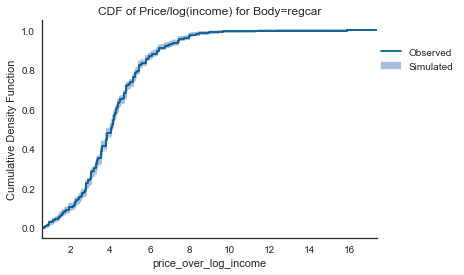

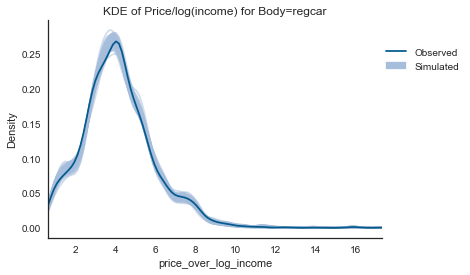

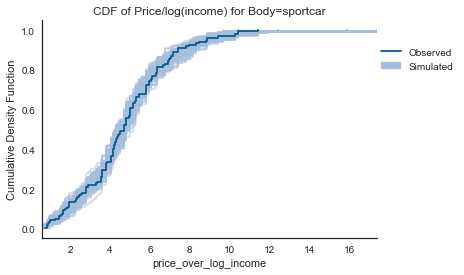

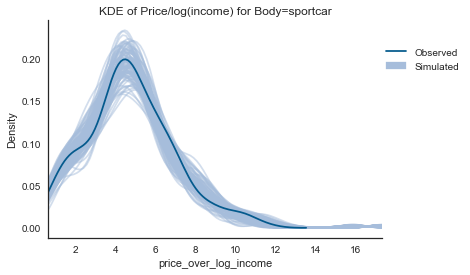

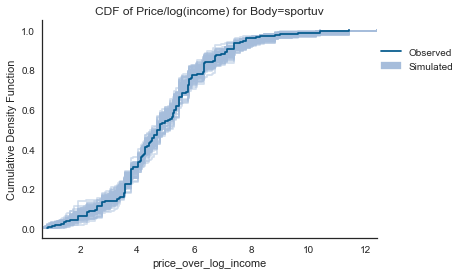

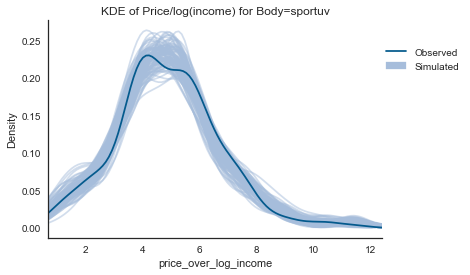

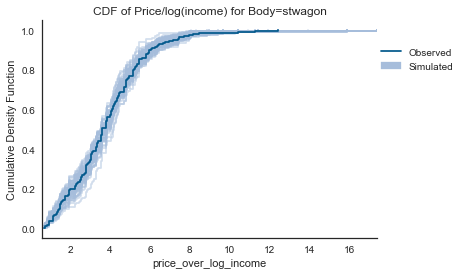

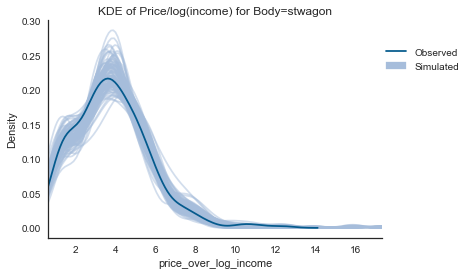

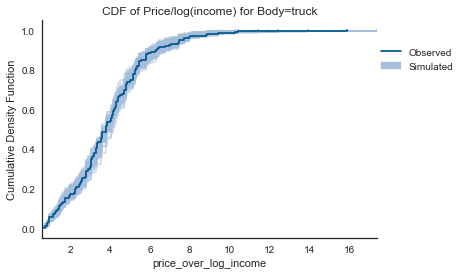

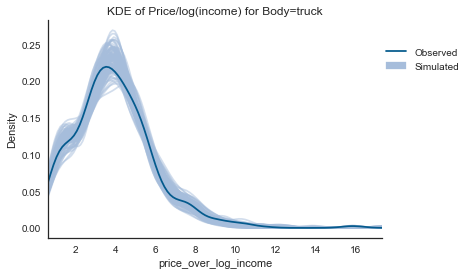

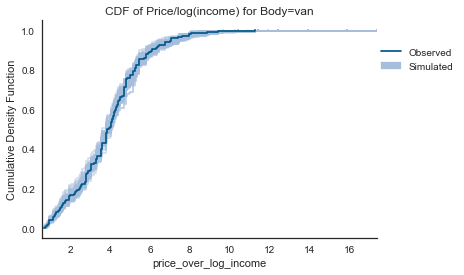

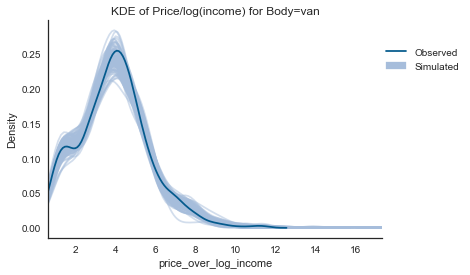

In [127]:
# Check the price variable for all of the various modes.
for body in np.sort(car_df.body_type.unique()):
    filter_row = car_df.body_type == body
    
    current_title = 'CDF of Price/log(income) for Body={}'
    
    viz.plot_simulated_cdf_traces(posterior_simulated_y,
                                  car_df,
                                  filter_row,
                                  'price_over_log_income',
                                  'choice',
                                  label='Simulated',
                                  title=current_title.format(body))
    
    title_2 = 'KDE of Price/log(income) for Body={}'
    viz.plot_simulated_kde_traces(posterior_simulated_y,
                                  car_df,
                                  filter_row,
                                  'price_over_log_income',
                                  'choice',
                                  label='Simulated',
                                  title=title_2.format(body))
    

From above, we see that we still have "mild" problems with the price variable. I'll move on though because there isn't much time.

In [25]:
# Check the log-likelihood at the posterior mode
bayes_log_like_at_mode =\
    np.log(interaction_model_full.predict(
            car_df,
            param_list=[bayes_mnl.posterior_mode.values,
                        None, None, None],
            return_long_probs=False,
            choice_col='choice')).sum()
print "The log-likelihood at the posterior mode is: {:.3f}".format(bayes_log_like_at_mode)

The log-likelihood at the posterior mode is: -7312.045


# Make predictions

In [29]:
# Create a new dataset where the price of the large gas cars rises by 20%
new_df = car_df.copy()

large_gas_car_idx = ((new_df['body_type'] == 'regcar') &
                     (new_df['vehicle_size'] == 3) &
                     (new_df['fuel_type'] == 'gasoline'))
new_df.loc[large_gas_car_idx, 'privce_over_log_income'] *= 1.2
                     
# Take the natural log of price/ln(income)
new_df['ln(price_over_log_income)'] =\
    np.log(new_df['price_over_log_income'])
    
# Create piecewise linear price variables
new_df['price_over_log_income_lte_3'] =\
    ((new_df['price_over_log_income'] <= 3) *
     new_df['price_over_log_income'] +
     (new_df['price_over_log_income'] > 3) * 3)
    
new_df['price_over_log_income_gt_3'] =\
    ((new_df['price_over_log_income'] > 3) *
     (new_df['price_over_log_income'] - 3))

In [68]:
# Create a set of values to use for grouping
grouping_series = [new_df.vehicle_size,
                   new_df.fuel_type,
                   new_df.body_type]

In [76]:
# Get the mode share by mode for the new data
new_probs_interaction_mnl =\
    pd.Series(interaction_model_full.predict(new_df))

# Get the new predicted mode shares
num_obs = float(new_df.choice.sum())
new_shares_interaction_mnl =\
    (new_probs_interaction_mnl.groupby(grouping_series)
                              .agg(np.sum) / num_obs)

# Get the originally predicted shares
orig_shares_interaction_mnl = (pd.Series(interaction_model_full.long_fitted_probs)
                 .groupby(grouping_series)
                 .agg(np.sum) / num_obs)

# Get the changes and percent changes for the original MNL model
change_interaction_mnl =\
    new_shares_interaction_mnl - orig_shares_interaction_mnl

pct_change_interaction_mnl = change_interaction_mnl / orig_shares_interaction_mnl

# Get the predictions for the original mnl model

In [44]:
car_mnl_spec, car_mnl_names = OrderedDict(), OrderedDict()

cols_and_display_names =\
    [('price_over_log_income', 'Price over log(income)'),
     ('range_over_100', 'Range (units: 100mi)'),
     ('acceleration_over_10', 'Acceleration (units: 0.1sec)'),
     ('top_speed_over_100', 'Top speed (units: 0.01mph)'),
     ('pollution', 'Pollution'),
     ('vehicle_size_over_10', 'Size'),
     ('big_enough', 'Big enough'),
     ('luggage_space', 'Luggage space'),
     ('tens_of_cents_per_mile', 'Operation cost'),
     ('station_availability', 'Station availability'),
     ('sports_utility_vehicle', 'Sports utility vehicle'),
     ('sports_car', 'Sports car'),
     ('station_wagon', 'Station wagon'),
     ('truck', 'Truck'),
     ('van', 'Van'),
     ('electric', 'EV'),
     ('electric_commute_lte_5mi', 'Commute < 5 & EV'),
     ('electric_and_college', 'College & EV'),
     ('compressed_natural_gas', 'CNG'),
     ('methanol', 'Methanol'),
     ('methanol_and_college', 'College & Methanol')]
    
for col, display_name in cols_and_display_names:
    car_mnl_spec[col] = 'all_same'
    car_mnl_names[col] = display_name

# Initialize the mnl model
car_mnl = pl.create_choice_model(data=car_df,
                                 alt_id_col='alt_id',
                                 obs_id_col='obs_id',
                                 choice_col='choice',
                                 specification=car_mnl_spec,
                                 model_type='MNL',
                                 names=car_mnl_names)

# Create the initial variables for model estimation
num_vars = len(car_mnl_names)
initial_vals = np.zeros(num_vars)

# Estimate the mnl model
fit_vals = car_mnl.fit_mle(initial_vals,
                           method='L-BFGS-B',
                           just_point=True)['x']
car_mnl.fit_mle(fit_vals, method='BFGS')

# Look at the estimation results
car_mnl.get_statsmodels_summary()# Initialize the mnl model
car_mnl = pl.create_choice_model(data=car_df,
                                 alt_id_col='alt_id',
                                 obs_id_col='obs_id',
                                 choice_col='choice',
                                 specification=car_mnl_spec,
                                 model_type='MNL',
                                 names=car_mnl_names)

# Create the initial variables for model estimation
num_vars = len(car_mnl_names)
initial_vals = np.zeros(num_vars)

# Estimate the mnl model
fit_vals = car_mnl.fit_mle(initial_vals,
                           method='L-BFGS-B',
                           just_point=True)['x']
car_mnl.fit_mle(fit_vals, method='BFGS')

# Look at the estimation results
car_mnl.get_statsmodels_summary()

/Users/timothyb0912/anaconda/lib/python2.7/site-packages/scipy/optimize/_minimize.py:385: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  RuntimeWarning)


Log-likelihood at zero: -8,338.8486
Initial Log-likelihood: -7,391.8638
Estimation Time for Point Estimation: 0.28 seconds.
Final log-likelihood: -7,391.8300
Log-likelihood at zero: -8,338.8486
Initial Log-likelihood: -7,391.8638
Estimation Time for Point Estimation: 0.31 seconds.
Final log-likelihood: -7,391.8300


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                4,654
Model:             Multinomial Logit Model   Df Residuals:                    4,633
Method:                                MLE   Df Model:                           21
Date:                     Mon, 15 Jan 2018   Pseudo R-squ.:                   0.114
Time:                             16:47:21   Pseudo R-bar-squ.:               0.111
AIC:                            14,825.660   Log-Likelihood:             -7,391.830
BIC:                            14,961.015   LL-Null:                    -8,338.849
================================================================================================
                                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
Price over log(income)          -0.1854      0.027     -6.796      0.000        -0.239    -0.132
Range (units: 100mi)             0.3501      0.027     13.052      0.000         0.298     0.403
Acceleration (units: 0.1sec)    -0.7160      0.111     -6.472      0.000        -0.933    -0.499
Top speed (units: 0.01mph)       0.2612      0.081      3.228      0.001         0.103     0.420
Pollution                       -0.4441      0.102     -4.367      0.000        -0.643    -0.245
Size                             0.9345      0.316      2.953      0.003         0.314     1.555
Big enough                       0.1432      0.077      1.853      0.064        -0.008     0.295
Luggage space                    0.5009      0.191      2.623      0.009         0.127     0.875
Operation cost                  -0.7679      0.076    -10.131      0.000        -0.916    -0.619
Station availability             0.4133      0.096      4.294      0.000         0.225     0.602
Sports utility vehicle           0.8201      0.141      5.830      0.000         0.544     1.096
Sports car                       0.6370      0.148      4.298      0.000         0.347     0.928
Station wagon                   -1.4367      0.062    -23.139      0.000        -1.558    -1.315
Truck                           -1.0168      0.049    -20.753      0.000        -1.113    -0.921
Van                             -0.7989      0.047    -16.864      0.000        -0.892    -0.706
EV                              -0.1786      0.172     -1.041      0.298        -0.515     0.158
Commute < 5 & EV                 0.1983      0.084      2.374      0.018         0.035     0.362
College & EV                     0.4426      0.109      4.058      0.000         0.229     0.656
CNG                              0.3450      0.092      3.744      0.000         0.164     0.526
Methanol                         0.3134      0.103      3.051      0.002         0.112     0.515
College & Methanol               0.2284      0.089      2.576      0.010         0.055     0.402
================================================================================================
"""

In [118]:
# Get the mode share by mode for the new data
new_probs_orig_mnl = pd.Series(car_mnl.predict(new_df))

# Get the new predicted mode shares
new_shares_orig_mnl =\
    (new_probs_orig_mnl.groupby(grouping_series)
                       .agg(np.sum) / num_obs)

# Get the original shares
orig_shares_orig_mnl = (pd.Series(car_mnl.long_fitted_probs)
                          .groupby(grouping_series)
                          .agg(np.sum) / num_obs)

# Get the change and percent change
change_orig_mnl =\
    new_shares_orig_mnl - orig_shares_orig_mnl

pct_change_orig_mnl = change_orig_mnl / orig_shares_orig_mnl


# Estimate the original mixed logit model and look at its aggregate substitutions

In [50]:
# Initialize the spec and names for mixed logit
mixed_spec = deepcopy(car_mnl_spec)
mixed_names = deepcopy(car_mnl_names)

# Create needed dummy variables
car_df['non_ev'] = (~car_df['electric']).astype(int)
car_df['non_cng'] = (~car_df['compressed_natural_gas']).astype(int)

# Add values to specification
mixed_spec['non_ev'] = 'all_same'
mixed_names['non_ev'] = 'Non-EV mean'

mixed_spec['non_cng'] = 'all_same'
mixed_names['non_cng'] = 'Non-CNG mean'

# Create mixing variable list
mixing_variables = [mixed_names['non_ev'],
                    mixed_names['non_cng'],
                    mixed_names['vehicle_size_over_10'],
                    mixed_names['luggage_space']]

# Determine the positions to be constrained
# These should be the non_ev mean and the non_cng mean.
constraints = [-1 * (1 + 4), -1 * (2 + 4)]

# Initialize the mixed logit model
mixed_mnl = pl.create_choice_model(data=car_df,
                                   alt_id_col="alt_id",
                                   obs_id_col="obs_id",
                                   choice_col="choice",
                                   specification=mixed_spec,
                                   model_type="Mixed Logit",
                                   names=mixed_names,
                                   mixing_id_col="obs_id",
                                   mixing_vars=mixing_variables)

# Create the initial values for the parameters
# being estimated. Note that we start at the MNL estimates
# and that we need to have initial variables for the
# standard deviation parameters that we'll estimate as well
# as for intercept for non_ev and non_cng
# (which we'll constrain to zero hence the '2 +')
initial_values = np.concatenate((car_mnl.params.values,
                                 np.zeros(2 + len(mixing_variables))))

# Estimate the model
num_draws = 250
random_seed = 100
mixed_mnl.fit_mle(initial_values,
                  seed=random_seed,
                  num_draws=num_draws,
                  constrained_pos=constraints)

# Look at the estimation results
mixed_mnl.get_statsmodels_summary()

Log-likelihood at zero: -8,338.8486
Initial Log-likelihood: -7,391.8300
Estimation Time for Point Estimation: 5.68 minutes.
Final log-likelihood: -7,368.4617


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Mixed Logit Model Regression Results                     
==============================================================================
Dep. Variable:                 choice   No. Observations:                4,654
Model:              Mixed Logit Model   Df Residuals:                    4,627
Method:                           MLE   Df Model:                           27
Date:                Mon, 15 Jan 2018   Pseudo R-squ.:                   0.116
Time:                        17:17:00   Pseudo R-bar-squ.:               0.113
AIC:                       14,790.923   Log-Likelihood:             -7,368.462
BIC:                       14,964.951   LL-Null:                    -8,338.849
================================================================================================
                                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
Price over log(income)          -0.2715      0.042     -6.425      0.000        -0.354    -0.189
Range (units: 100mi)             0.5481      0.063      8.717      0.000         0.425     0.671
Acceleration (units: 0.1sec)    -0.9554      0.166     -5.772      0.000        -1.280    -0.631
Top speed (units: 0.01mph)       0.3127      0.116      2.702      0.007         0.086     0.540
Pollution                       -0.6444      0.142     -4.541      0.000        -0.922    -0.366
Size                             1.5373      0.508      3.025      0.002         0.541     2.533
Big enough                       0.2216      0.111      1.994      0.046         0.004     0.439
Luggage space                    1.0390      0.399      2.607      0.009         0.258     1.820
Operation cost                  -1.1507      0.126     -9.150      0.000        -1.397    -0.904
Station availability             0.6731      0.155      4.343      0.000         0.369     0.977
Sports utility vehicle           0.9069      0.149      6.082      0.000         0.615     1.199
Sports car                       0.6891      0.162      4.250      0.000         0.371     1.007
Station wagon                   -1.5004      0.067    -22.281      0.000        -1.632    -1.368
Truck                           -1.0954      0.056    -19.661      0.000        -1.205    -0.986
Van                             -0.8131      0.056    -14.631      0.000        -0.922    -0.704
EV                              -0.9574      0.411     -2.327      0.020        -1.764    -0.151
Commute < 5 & EV                 0.3326      0.157      2.115      0.034         0.024     0.641
College & EV                     0.7744      0.209      3.700      0.000         0.364     1.185
CNG                              0.3692      0.153      2.415      0.016         0.070     0.669
Methanol                         0.4812      0.142      3.381      0.001         0.202     0.760
College & Methanol               0.3204      0.111      2.899      0.004         0.104     0.537
Non-EV mean                           0        nan        nan        nan           nan       nan
Non-CNG mean                          0        nan        nan        nan           nan       nan
Sigma Non-EV mean               -2.4937      0.482     -5.172      0.000        -3.439    -1.549
Sigma Non-CNG mean               1.7360      0.398      4.363      0.000         0.956     2.516
Sigma Size                      -7.2975      1.868     -3.906      0.000       -10.959    -3.636
Sigma Luggage space              2.6309      1.811      1.452      0.146        -0.919     6.181
================================================================================================
"""

In [51]:
random_seed = 100

In [52]:
mixed_mnl.long_fitted_probs.shape

(27924, 250)

In [117]:
# Create a new dataframe for the mixed logit model
# with the appropriate changes in price
new_df_2 = car_df.copy()
large_gas_car_idx = ((new_df_2['body_type'] == 'regcar') &
                     (new_df_2['vehicle_size'] == 3) &
                     (new_df_2['fuel_type'] == 'gasoline'))
new_df_2.loc[large_gas_car_idx, 'price_over_log_income'] *= 1.2
                     
# Take the natural log of price/ln(income)
new_df_2['ln(price_over_log_income)'] =\
    np.log(new_df_2['price_over_log_income'])
    
# Create piecewise linear price variables
new_df_2['price_over_log_income_lte_3'] =\
    ((new_df_2['price_over_log_income'] <= 3) *
     new_df_2['price_over_log_income'] +
     (new_df_2['price_over_log_income'] > 3) * 3)
    
new_df_2['price_over_log_income_gt_3'] =\
    ((new_df_2['price_over_log_income'] > 3) *
     (new_df_2['price_over_log_income'] - 3))

# Get the mode share by mode for the new data
new_probs_mixed_mnl = pd.Series(mixed_mnl.predict(new_df_2,
                                                  seed=random_seed,
                                                  num_draws=num_draws))

# Get the new predicted mode shares
new_shares_mixed_mnl =\
    (new_probs_mixed_mnl.groupby(grouping_series)
                       .agg(np.sum) / num_obs)

# Get the original shares
orig_shares_mixed_mnl = (pd.Series(mixed_mnl.long_fitted_probs
                                            .mean(axis=1))
                           .groupby(grouping_series)
                           .agg(np.sum) / num_obs)

# Get the change and percent change
change_orig_mixed =\
    new_shares_mixed_mnl - orig_shares_mixed_mnl

pct_change_orig_mixed = change_orig_mixed / orig_shares_mixed_mnl


# Estimate a new mixed logit model based on the interaction + piecewise MNL

In [64]:
# Initialize the spec and names for mixed logit
mixed_interaction_spec = deepcopy(interaction_mnl_spec_full)
mixed_interaction_names = deepcopy(interaction_mnl_names_full)

# Add values to specification
mixed_interaction_spec['non_ev'] = 'all_same'
mixed_interaction_names['non_ev'] = 'Non-EV mean'

mixed_interaction_spec['non_cng'] = 'all_same'
mixed_interaction_names['non_cng'] = 'Non-CNG mean'

# Create mixing variable list
mixing_interaction_variables =\
                   [mixed_interaction_names['non_ev'],
                    mixed_interaction_names['non_cng'],
                    mixed_interaction_names['vehicle_size_over_10'],
                    mixed_interaction_names['luggage_space']]

# Determine the positions to be constrained
# These should be the non_ev mean and the non_cng mean.
interaction_constraints = [-1 * (1 + 4), -1 * (2 + 4)]

# Initialize the mixed logit model
mixed_interaction_mnl = pl.create_choice_model(data=car_df,
                                   alt_id_col="alt_id",
                                   obs_id_col="obs_id",
                                   choice_col="choice",
                                   specification=mixed_interaction_spec,
                                   model_type="Mixed Logit",
                                   names=mixed_interaction_names,
                                   mixing_id_col="obs_id",
                                   mixing_vars=mixing_interaction_variables)

# Create the initial values for the parameters
# being estimated. Note that we start at the MNL estimates
# and that we need to have initial variables for the
# standard deviation parameters that we'll estimate as well
# as for intercept for non_ev and non_cng
# (which we'll constrain to zero hence the '2 +')
initial_interaction_values = np.concatenate((interaction_model_full.params.values,
                                 np.zeros(2 + len(mixing_interaction_variables))))

# Estimate the model
num_draws = 250
random_seed = 100
mixed_interaction_mnl.fit_mle(initial_interaction_values,
                  seed=random_seed,
                  num_draws=num_draws,
                  constrained_pos=interaction_constraints)

# Look at the estimation results
mixed_interaction_mnl.get_statsmodels_summary()

Log-likelihood at zero: -8,338.8486
Initial Log-likelihood: -7,311.6340
Estimation Time for Point Estimation: 27.59 minutes.
Final log-likelihood: -7,290.6205


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Mixed Logit Model Regression Results                     
==============================================================================
Dep. Variable:                 choice   No. Observations:                4,654
Model:              Mixed Logit Model   Df Residuals:                    4,566
Method:                           MLE   Df Model:                           88
Date:                Mon, 15 Jan 2018   Pseudo R-squ.:                   0.126
Time:                        18:34:52   Pseudo R-bar-squ.:               0.115
AIC:                       14,757.241   Log-Likelihood:             -7,290.620
BIC:                       15,324.443   LL-Null:                    -8,338.849
=========================================================================================================================
                                                            coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------------------------
Price over log(income) <= 3 (sports_utility_vehicle)      0.0779      0.309      0.252      0.801        -0.528     0.684
Price over log(income) <= 3 (sports_car)                 -0.2199      0.274     -0.801      0.423        -0.758     0.318
Price over log(income) <= 3 (station_wagon)              -0.3198      0.122     -2.618      0.009        -0.559    -0.080
Price over log(income) <= 3 (truck)                      -0.2846      0.102     -2.793      0.005        -0.484    -0.085
Price over log(income) <= 3 (van)                        -0.2553      0.101     -2.533      0.011        -0.453    -0.058
Price over log(income) <= 3(electric)                    -0.2348      0.185     -1.266      0.205        -0.598     0.129
Price over log(income) <= 3(compressed_natural_gas)      -0.1630      0.150     -1.090      0.276        -0.456     0.130
Price over log(income) <= 3(methanol)                     0.1352      0.108      1.252      0.211        -0.076     0.347
Price over log(income) <= 3                              -0.5351      0.168     -3.179      0.001        -0.865    -0.205
Price over log(income) > 3 (sports_utility_vehicle)       0.3366      0.087      3.887      0.000         0.167     0.506
Price over log(income) > 3 (sports_car)                   0.2579      0.075      3.450      0.001         0.111     0.404
Price over log(income) > 3 (station_wagon)               -0.0439      0.050     -0.872      0.383        -0.143     0.055
Price over log(income) > 3 (truck)                       -0.0017      0.037     -0.046      0.963        -0.073     0.070
Price over log(income) > 3 (van)                         -0.0420      0.043     -0.975      0.329        -0.126     0.042
Price over log(income) > 3(electric)                     -0.1520      0.059     -2.593      0.010        -0.267    -0.037
Price over log(income) > 3(compressed_natural_gas)       -0.0753      0.055     -1.377      0.169        -0.182     0.032
Price over log(income) > 3(methanol)                     -0.0886      0.037     -2.390      0.017        -0.161    -0.016
Price over log(income) > 3                               -0.2024      0.053     -3.789      0.000        -0.307    -0.098
Range (units: 100mi) (sports_utility_vehicle)            -0.1860      0.134     -1.383      0.167        -0.450     0.078
Range (units: 100mi) (sports_car)                        -0.1244      0.158     -0.788      0.431        -0.434     0.185
Range (units: 100mi) (station_wagon)                     -0.0476      0.098     -0.487      0.626        -0.239     0.144
Range (units: 100mi) (truck)                              0.0116      0.074      0.157      0.876        -0.133     0.156
Range (units: 100mi) (van)                                0.0435      0.072      0.603      0.546        -0.098     0.185
Range (units: 100mi)(electric)                            0.4301     

In [115]:
# Get the mode share by mode for the new data
new_probs_mixed_interaction_mnl =\
    pd.Series(mixed_interaction_mnl.predict(new_df_2,
                                            seed=random_seed,
                                            num_draws=num_draws))

# Get the new predicted mode shares
new_shares_mixed_interaction_mnl =\
    (new_probs_mixed_interaction_mnl.groupby(grouping_series)
                       .agg(np.sum) / num_obs)

# Get the original shares
orig_shares_mixed_interaction_mnl =\
    (pd.Series(mixed_interaction_mnl.long_fitted_probs
                                    .mean(axis=1))
       .groupby(grouping_series)
       .agg(np.sum) / num_obs)

# Get the change and percent change
change_orig_mixed_interaction =\
    (new_shares_mixed_interaction_mnl -
     orig_shares_mixed_interaction_mnl)

pct_change_orig_mixed_interaction =\
    (change_orig_mixed_interaction /
     orig_shares_mixed_interaction_mnl)

# Compare aggregate substitutions

In [116]:
change_df =\
    pd.DataFrame({'MNL': change_orig_mnl,
                 'Mixed': change_orig_mixed,
                 'Interaction': change_interaction_mnl,
                 'Interaction Mixed': change_orig_mixed_interaction})
pct_change_df =\
    pd.DataFrame({'MNL': pct_change_orig_mnl,
             'Mixed': pct_change_orig_mixed,
             'Interaction': pct_change_interaction_mnl,
             'Interaction Mixed': pct_change_orig_mixed_interaction})
desired_order = ['MNL', 'Mixed', 'Interaction', 'Interaction Mixed']


In [90]:
big_change_pct =\
    (((pct_change_df['Interaction Mixed'] >= 2 * pct_change_df['Mixed']) & (pct_change_df['Mixed'] > 0)) |
     ((pct_change_df['Interaction Mixed'] <= 0.5 * pct_change_df['Mixed']) & (pct_change_df['Mixed'] > 0)) |
     ((pct_change_df['Interaction Mixed'] <= 2 * pct_change_df['Mixed']) & (pct_change_df['Mixed'] < 0)) |
     ((pct_change_df['Interaction Mixed'] >= 0.5 * pct_change_df['Mixed']) & (pct_change_df['Mixed'] < 0)))
    
pct_change_df.loc[big_change_pct]

Interaction  Interaction Mixed       MNL  \
vehicle_size fuel_type body_type                                             
3            cng       sportcar      0.001067           0.000967  0.002090   
                       sportuv       0.000368           0.000318  0.000726   

                                     Mixed  
vehicle_size fuel_type body_type            
3            cng       sportcar   0.002057  
                       sportuv    0.000639

In [91]:
big_change =\
    (((change_df['Interaction Mixed'] >= 2 * change_df['Mixed']) & (change_df['Mixed'] > 0)) |
     ((change_df['Interaction Mixed'] <= 0.5 * change_df['Mixed']) & (change_df['Mixed'] > 0)) |
     ((change_df['Interaction Mixed'] <= 2 * change_df['Mixed']) & (change_df['Mixed'] < 0)) |
     ((change_df['Interaction Mixed'] >= 0.5 * change_df['Mixed']) & (change_df['Mixed'] < 0)))
    
change_df.loc[big_change]

,,,Interaction,Interaction Mixed,MNL,Mixed
vehicle_size,fuel_type,body_type,,,,
0,cng,sportcar,5.913656e-06,5.234896e-06,0.000003,0.000002
3,cng,sportcar,8.925114e-07,7.131967e-07,0.000003,0.000002


In [93]:
mixed_interaction_mnl.model_type

'Mixed Logit Model'

In [103]:
def generate_change_dfs(old_data,
                        new_data,
                        ordered_model_dict,
                        grouping_obj,
                        rseed=None,
                        num_draws=250):
    # Initialize a container to store the predictions
    change_series = OrderedDict()
    pct_change_series = OrderedDict()

    # Iterate over the various models
    for model_name in ordered_model_dict:
        model = ordered_model_dict[model_name]
        
        # Make needed predictions
        if model.model_type != 'Mixed Logit Model':
            # Make predictions on old data
            old_predictions = pd.Series(model.long_fitted_probs)

            # Make predictions on new data
            new_predictions = pd.Series(model.predict(new_data))
        else:
            # Make predictions on old data
            old_predictions =\
                pd.Series(model.long_fitted_probs.mean(axis=1))

            # Make predictions on new data
            new_predictions =\
                pd.Series(model.predict(new_data,
                                        seed=rseed,
                                        num_draws=num_draws))
    
        # Get old, aggregate, group mode shares
        grouped_old_predictions =\
            old_predictions.groupby(grouping_obj).agg(np.sum)
    
        # Group new, aggregate, group mode shares
        grouped_new_predictions =\
            new_predictions.groupby(grouping_obj).agg(np.sum)
    
        # Compute change
        current_change =\
            grouped_new_predictions - grouped_old_predictions

        # Compute percent change
        current_pct_change = current_change / grouped_old_predictions

        # Store change and percent change
        change_series[model_name] = current_change
        pct_change_series[model_name] = current_pct_change
    
    # Combine change series into dataframes
    changes = pd.DataFrame(change_series)
    pct_changes = pd.DataFrame(pct_change_series)
    
    # Return combined dataframes
    return changes, pct_changes
    

# Create a mixed logit model that is closer to the model that Brownstone and Train originally wanted.

In [95]:
# Initialize the spec and names for mixed logit
mixed_spec_2 = deepcopy(mixed_spec)
mixed_names_2 = deepcopy(mixed_names)

# Create mixing variable list
mixing_variables_2 = [mixed_names['non_ev'],
                      mixed_names['non_cng'],
                      mixed_names['vehicle_size_over_10'],
                      mixed_names['luggage_space'],
                      mixed_names['price_over_log_income']]

# Determine the positions to be constrained
# These should be the non_ev mean and the non_cng mean.
constraints_2 = [-1 * (1 + len(mixing_variables_2)),
                 -1 * (2 + len(mixing_variables_2))]

# Initialize the mixed logit model
mixed_mnl_2 = pl.create_choice_model(data=car_df,
                                   alt_id_col="alt_id",
                                   obs_id_col="obs_id",
                                   choice_col="choice",
                                   specification=mixed_spec_2,
                                   model_type="Mixed Logit",
                                   names=mixed_names_2,
                                   mixing_id_col="obs_id",
                                   mixing_vars=mixing_variables_2)

# Create the initial values for the parameters
# being estimated. Note that we start at the MNL estimates
# and that we need to have initial variables for the
# standard deviation parameters that we'll estimate as well
# as for intercept for non_ev and non_cng
# (which we'll constrain to zero hence the '2 +')
initial_values_2 = np.concatenate((car_mnl.params.values,
                                   np.zeros(2 + len(mixing_variables_2))))

# Estimate the model
num_draws = 250
random_seed = 100
mixed_mnl_2.fit_mle(initial_values_2,
                    seed=random_seed,
                    num_draws=num_draws,
                    constrained_pos=constraints_2)

# Look at the estimation results
mixed_mnl_2.get_statsmodels_summary()

Log-likelihood at zero: -8,338.8486
Initial Log-likelihood: -7,391.8300
Estimation Time for Point Estimation: 6.75 minutes.
Final log-likelihood: -7,366.3316


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Mixed Logit Model Regression Results                     
==============================================================================
Dep. Variable:                 choice   No. Observations:                4,654
Model:              Mixed Logit Model   Df Residuals:                    4,626
Method:                           MLE   Df Model:                           28
Date:                Mon, 15 Jan 2018   Pseudo R-squ.:                   0.117
Time:                        21:33:24   Pseudo R-bar-squ.:               0.113
AIC:                       14,788.663   Log-Likelihood:             -7,366.332
BIC:                       14,969.137   LL-Null:                    -8,338.849
================================================================================================
                                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
Price over log(income)          -0.2983      0.049     -6.071      0.000        -0.395    -0.202
Range (units: 100mi)             0.5753      0.069      8.345      0.000         0.440     0.710
Acceleration (units: 0.1sec)    -0.9936      0.177     -5.619      0.000        -1.340    -0.647
Top speed (units: 0.01mph)       0.3311      0.122      2.713      0.007         0.092     0.570
Pollution                       -0.6759      0.151     -4.470      0.000        -0.972    -0.380
Size                             1.6367      0.540      3.030      0.002         0.578     2.696
Big enough                       0.2293      0.117      1.956      0.051        -0.001     0.459
Luggage space                    1.0813      0.413      2.615      0.009         0.271     1.892
Operation cost                  -1.2041      0.138     -8.739      0.000        -1.474    -0.934
Station availability             0.7037      0.164      4.285      0.000         0.382     1.026
Sports utility vehicle           0.9124      0.149      6.107      0.000         0.620     1.205
Sports car                       0.6962      0.163      4.279      0.000         0.377     1.015
Station wagon                   -1.5060      0.068    -22.280      0.000        -1.639    -1.374
Truck                           -1.1032      0.056    -19.792      0.000        -1.212    -0.994
Van                             -0.8129      0.056    -14.566      0.000        -0.922    -0.703
EV                              -1.0363      0.439     -2.359      0.018        -1.897    -0.175
Commute < 5 & EV                 0.3544      0.167      2.116      0.034         0.026     0.683
College & EV                     0.8172      0.223      3.665      0.000         0.380     1.254
CNG                              0.3903      0.160      2.439      0.015         0.077     0.704
Methanol                         0.4886      0.150      3.262      0.001         0.195     0.782
College & Methanol               0.3485      0.117      2.972      0.003         0.119     0.578
Non-EV mean                           0        nan        nan        nan           nan       nan
Non-CNG mean                          0        nan        nan        nan           nan       nan
Sigma Non-EV mean               -2.6674      0.523     -5.104      0.000        -3.692    -1.643
Sigma Non-CNG mean               1.8169      0.423      4.295      0.000         0.988     2.646
Sigma Size                      -7.7914      1.971     -3.952      0.000       -11.655    -3.927
Sigma Luggage space              2.5538      1.974      1.294      0.196        -1.315     6.422
Sigma Price over log(income)     0.6227      0.246      2.535      0.011         0.141     1.104
================================================================================================
"""

In [99]:
# Create the current model dict
current_model_dict = OrderedDict()
current_model_dict['MNL'] = car_mnl
current_model_dict['Interaction'] = interaction_model_full
current_model_dict['Mixed'] = mixed_mnl
current_model_dict['Mixed with Price'] = mixed_mnl_2
current_model_dict['Interaction Mixed'] = mixed_interaction_mnl

In [104]:
# Get the change and pct_change dataframes
new_change_df, new_pct_change_df =\
    generate_change_dfs(car_df,
                        new_df_2,
                        current_model_dict,
                        grouping_series,
                        rseed=random_seed, num_draws=num_draws)

In [106]:
big_change_pct =\
    (((new_pct_change_df['Interaction Mixed'] >= 2 * new_pct_change_df['Mixed with Price']) &
      (new_pct_change_df['Mixed with Price'] > 0)) |
     ((new_pct_change_df['Interaction Mixed'] <= 0.5 * new_pct_change_df['Mixed with Price']) &
      (new_pct_change_df['Mixed with Price'] > 0)) |
     ((new_pct_change_df['Interaction Mixed'] <= 2 * new_pct_change_df['Mixed with Price']) &
      (new_pct_change_df['Mixed with Price'] < 0)) |
     ((new_pct_change_df['Interaction Mixed'] >= 0.5 * new_pct_change_df['Mixed with Price']) &
      (new_pct_change_df['Mixed with Price'] < 0)))
    
new_pct_change_df.loc[big_change_pct]

MNL  Interaction     Mixed  \
vehicle_size fuel_type body_type                                    
0            cng       sportcar   0.001220     0.001834  0.000866   
1            electric  sportuv    0.003050     0.002682  0.002923   
2            electric  sportcar   0.001386     0.001865  0.001075   
                       sportuv    0.000497     0.000418  0.000650   

                                  Mixed with Price  Interaction Mixed  
vehicle_size fuel_type body_type                                       
0            cng       sportcar           0.000672           0.001662  
1            electric  sportuv            0.001024           0.002668  
2            electric  sportcar           0.000503           0.002119  
                       sportuv           -0.000556           0.000393

In [126]:
big_change =\
    (((new_change_df['Interaction Mixed'] >= 2 * new_change_df['Mixed with Price']) &
      (new_change_df['Mixed with Price'] > 0)) |
     ((new_change_df['Interaction Mixed'] <= 0.5 * new_change_df['Mixed with Price']) &
      (new_change_df['Mixed with Price'] > 0)) |
     ((new_change_df['Interaction Mixed'] <= 2 * new_change_df['Mixed with Price']) &
      (new_change_df['Mixed with Price'] < 0)) |
     ((new_change_df['Interaction Mixed'] >= 0.5 * new_change_df['Mixed with Price']) &
      (new_change_df['Mixed with Price'] < 0)))
    
new_change_df.loc[big_change]

MNL  Interaction     Mixed  \
vehicle_size fuel_type body_type                                    
0            cng       sportcar   0.011898     0.027522  0.008536   
1            electric  sportuv    0.017122     0.012659  0.016676   
2            electric  sportcar   0.014286     0.013055  0.011716   
                       sportuv    0.005298     0.004559  0.006895   

                                  Mixed with Price  Interaction Mixed  
vehicle_size fuel_type body_type                                       
0            cng       sportcar           0.006684           0.024363  
1            electric  sportuv            0.005853           0.013647  
2            electric  sportcar           0.005516           0.016477  
                       sportuv           -0.005946           0.004348

In [109]:
# Get the old and new predicted probabilities for the mixed logit model
# that includes mixing of the price coefficient.
old_mixed_with_price_preds =\
    pd.Series(mixed_mnl_2.long_fitted_probs.mean(axis=1))

new_mixed_with_price_preds =\
    pd.Series(mixed_mnl_2.predict(new_df_2,
                                  seed=random_seed,
                                  num_draws=num_draws))

In [112]:
# Find large regular car decision makers
increasing_probs_mixed_with_price =\
    (new_mixed_with_price_preds.loc[large_gas_car_idx] >
     old_mixed_with_price_preds.loc[large_gas_car_idx])

old_probs_mixed_interaction_mnl =\
    pd.Series(mixed_interaction_mnl.long_fitted_probs.mean(axis=1))

increasing_probs_interaction_mixed =\
    (new_probs_mixed_interaction_mnl.loc[large_gas_car_idx] >
     old_probs_mixed_interaction_mnl.loc[large_gas_car_idx])

In [113]:
increasing_probs_mixed_with_price.sum()

34

In [114]:
increasing_probs_interaction_mixed.sum()

0

# Check the mixed logit models!

## Interaction Mixed logit

In [122]:
# Get the sampling distribution
interaction_mixed_sampling_dist =\
    scipy.stats.multivariate_normal(mean=mixed_interaction_mnl.params.values,
                                    cov=mixed_interaction_mnl.cov)

# Take Draws from the sampling distribution
num_draws = 500
interaction_mixed_simulated_coefs = interaction_mixed_sampling_dist.rvs(num_draws)

# Predict the model probabilities
interaction_mixed_simulated_probs =\
    [mixed_interaction_mnl.predict(
        car_df, param_list=[interaction_mixed_simulated_coefs[i, :], None, None, None],
        num_draws=250,
        seed=random_seed) for i in range(interaction_mixed_simulated_coefs.shape[0])]

# Simulate y from the sampling distribution
interaction_mixed_sim_y =\
    viz.simulate_choice_vector(interaction_mixed_simulated_probs,
                               car_df['obs_id'].values,
                               rseed=1122018)

AttributeError: 'list' object has no attribute 'ndim'

In [123]:
# Simulate y from the sampling distribution
interaction_mixed_sim_y =\
    viz.simulate_choice_vector(np.concatenate([x[:, None] for x in interaction_mixed_simulated_probs],
                                              axis=1),
                               car_df['obs_id'].values,
                               rseed=1122018)

Simulating Choices: 100%|██████████| 4654/4654 [00:00<00:00, 8573.29it/s]


Calculating KDEs: 100%|██████████| 100/100 [00:00<00:00, 198.94it/s]


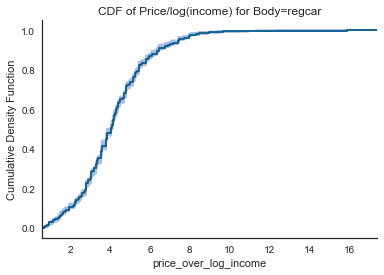

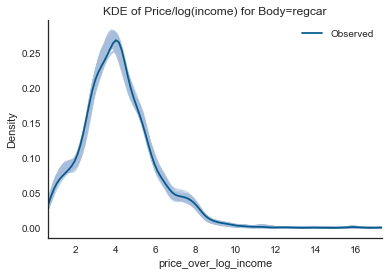

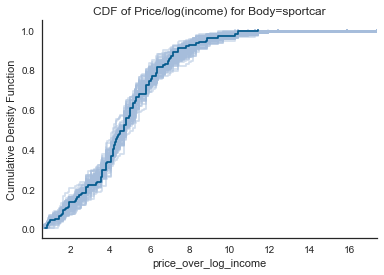

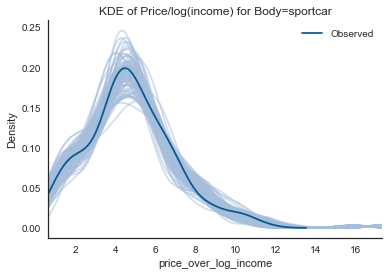

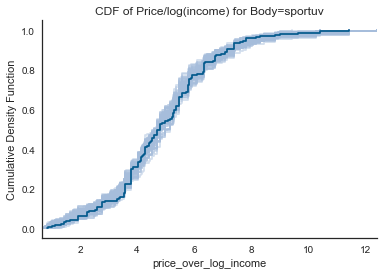

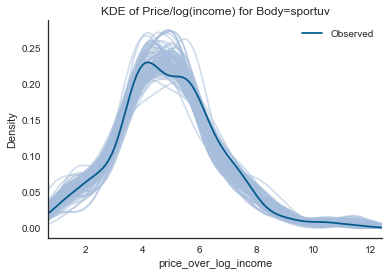

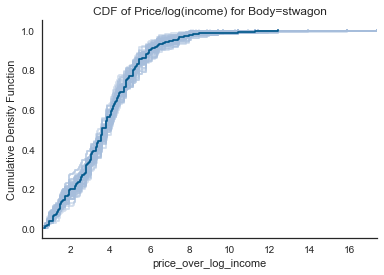

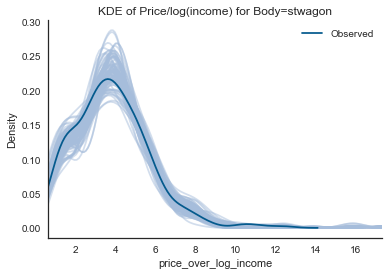

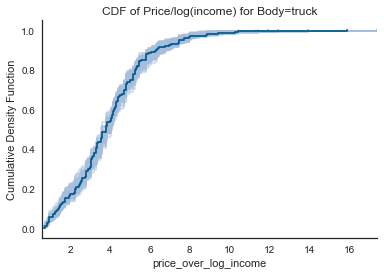

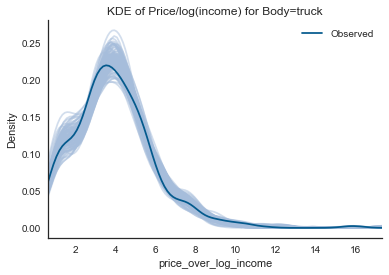

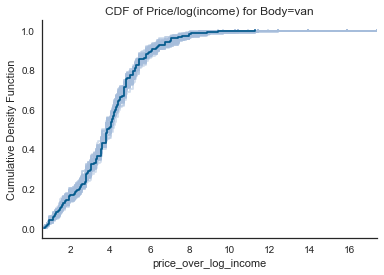

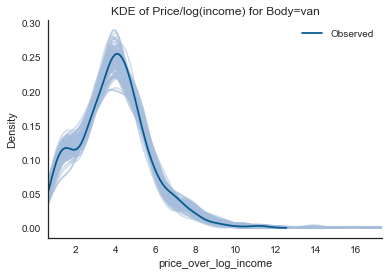

In [124]:
# Check the price variable for all of the various modes.
for body in np.sort(car_df.body_type.unique()):
    
    filter_row = car_df.body_type == body
    
    current_title = 'CDF of Price/log(income) for Body={}'
    
    viz.plot_simulated_cdf_traces(interaction_mixed_sim_y,
                                  car_df,
                                  filter_row,
                                  'price_over_log_income',
                                  'choice',
                                  title=current_title.format(body))
    
    title_2 = 'KDE of Price/log(income) for Body={}'
    viz.plot_simulated_kde_traces(interaction_mixed_sim_y,
                                  car_df,
                                  filter_row,
                                  'price_over_log_income',
                                  'choice',
                                  title=title_2.format(body))
    

## Check the original mixed logit with price mixing

In [125]:
from tqdm import tqdm

In [ ]:
# Get the sampling distribution
mixed_sampling_dist_2 =\
    scipy.stats.multivariate_normal(mean=mixed_mnl_2.params.values,
                                    cov=mixed_mnl_2.cov)

# Take Draws from the sampling distribution
num_draws = 500
mixed_simulated_coefs_2 = mixed_sampling_dist_2.rvs(num_draws)

# Predict the model probabilities
mixed_simulated_probs_2 =\
    [mixed_mnl_2.predict(
        car_df, param_list=[mixed_simulated_coefs_2[i, :], None, None, None],
        num_draws=250,
        seed=random_seed) for i in tqdm(range(mixed_simulated_coefs_2.shape[0]))]

# Simulate y from the sampling distribution
mixed_sim_y_2 =\
    viz.simulate_choice_vector(np.concatenate([x[:, None] for x in mixed_simulated_probs_2],
                                              axis=1),
                               car_df['obs_id'].values,
                               rseed=1122018)

In [ ]:
# Check the price variable for all of the various modes.
for body in np.sort(car_df.body_type.unique()):
    filter_row = car_df.body_type == body
    
    current_title = 'CDF of Price/log(income) for Body={}'
    
    viz.plot_simulated_cdf_traces(interaction_mixed_sim_y,
                                  car_df,
                                  filter_row,
                                  'price_over_log_income',
                                  'choice',
                                  title=current_title.format(body))
    
    title_2 = 'KDE of Price/log(income) for Body={}'
    viz.plot_simulated_kde_traces(interaction_mixed_sim_y,
                                  car_df,
                                  filter_row,
                                  'price_over_log_income',
                                  'choice',
                                  title=title_2.format(body))
    

# Key Takeaways

Accounting for systematic heterogeneity improved the model fit more than accounting for unobserved heterogeneity.

Accounting for sytematic heterogeneity (likely) improved the model fit on substantive features more than accounting for unobserved heterogeneity.

